# Análisis de Agrupamiento para Conjunto de Datos de Control de Calidad

Este cuaderno realiza análisis de agrupamiento utilizando K-means, DBSCAN y Agrupamiento Espectral en el conjunto de datos reducido por UMAP de Dimensionality_Reduction.ipynb. El objetivo es identificar patrones en los datos de control de calidad, detectar anomalías y evaluar el rendimiento del agrupamiento.

## Importar Librerías

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# Establecer estilo
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Cargar Datos

In [15]:
# Cargar conjunto de datos reducido
import pandas as pd

df_reduced = pd.read_csv('reduced_dataset_umap.csv')

# Cargar conjunto de datos original para análisis de características
# Asumiendo preprocesado es dataset.csv
# Si hubiera un ID común (ItemID) se podría hacer un merge para garantizar alineación.
df_original = pd.read_csv('dataset.csv')

# Extraer componentes UMAP
X_reduced = df_reduced[['UMAP1', 'UMAP2']].values

# Extraer características originales (numéricas)
numerical_cols = [col for col in df_original.columns if col not in ['ItemID', 'LotNumber', 'manufacturedDate']]
X_original = df_original[numerical_cols]

# Etiquetas completas de lotes (tamaño original)
lot_labels_full = df_original['LotNumber']

# Alinear etiquetas con datos reducidos:
# Estrategia: si df_reduced trae LotNumber, usarlo directamente; si no, truncar al mismo número de filas (asumiendo mismo orden preprocesado)
if 'LotNumber' in df_reduced.columns:
    lot_labels_reduced = df_reduced['LotNumber']
else:
    lot_labels_reduced = lot_labels_full.iloc[:len(df_reduced)].reset_index(drop=True)

print(f"Forma de datos reducidos: {X_reduced.shape}")
print(f"Forma de datos originales: {X_original.shape}")
print(f"Número de lotes (original): {lot_labels_full.nunique()}")
print(f"Longitud etiquetas reducidas: {len(lot_labels_reduced)}")

Forma de datos reducidos: (3907, 2)
Forma de datos originales: (6114, 21)
Número de lotes (original): 6114
Longitud etiquetas reducidas: 3907


## Funciones Auxiliares

In [16]:
# Cálculo del Índice de Dunn
def dunn_index(X, labels):
    import numpy as np
    from scipy.spatial.distance import pdist
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0
    # Intra-cluster distances (max diameter)
    intra_dists = []
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            dists = pdist(cluster_points)
            intra_dists.append(np.max(dists))
        else:
            intra_dists.append(0)
    max_intra = np.max(intra_dists)
    # Inter-cluster distances (min separation)
    inter_dists = []
    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            cluster_i = X[labels == unique_labels[i]]
            cluster_j = X[labels == unique_labels[j]]
            # pairwise min distance
            dists = [np.linalg.norm(p - q) for p in cluster_i for q in cluster_j]
            inter_dists.append(np.min(dists))
    min_inter = np.min(inter_dists)
    return min_inter / max_intra if max_intra > 0 else 0

# Función para evaluar agrupamiento (robusta a desalineación en etiquetas externas)
def evaluate_clustering(X, labels, true_labels=None):
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score
    import numpy as np
    metrics = {}
    # Internal metrics
    if len(np.unique(labels)) > 1:
        metrics['silhouette'] = silhouette_score(X, labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X, labels)
        metrics['dunn'] = dunn_index(X, labels)
    else:
        metrics['silhouette'] = -1
        metrics['davies_bouldin'] = -1
        metrics['calinski_harabasz'] = -1
        metrics['dunn'] = -1
    # External metrics if available and lengths match
    if true_labels is not None:
        if len(true_labels) == len(labels):
            metrics['adjusted_rand'] = adjusted_rand_score(true_labels, labels)
            metrics['homogeneity'] = homogeneity_score(true_labels, labels)
            metrics['completeness'] = completeness_score(true_labels, labels)
        else:
            metrics['external_warning'] = f"Skipped external metrics (length mismatch {len(true_labels)} vs {len(labels)})"
    return metrics

## Agrupamiento K-means

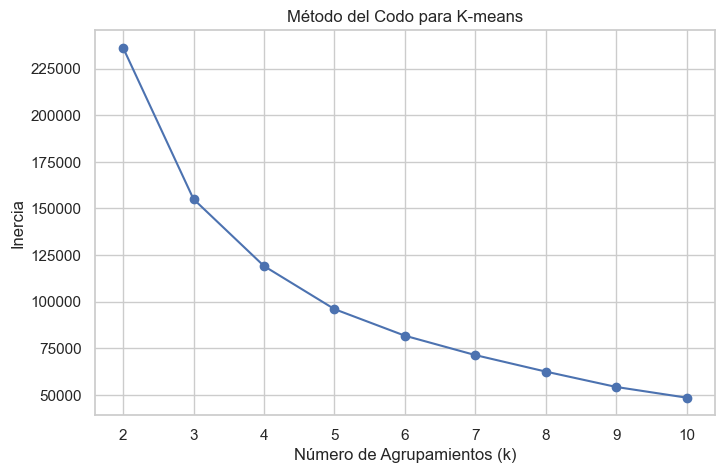

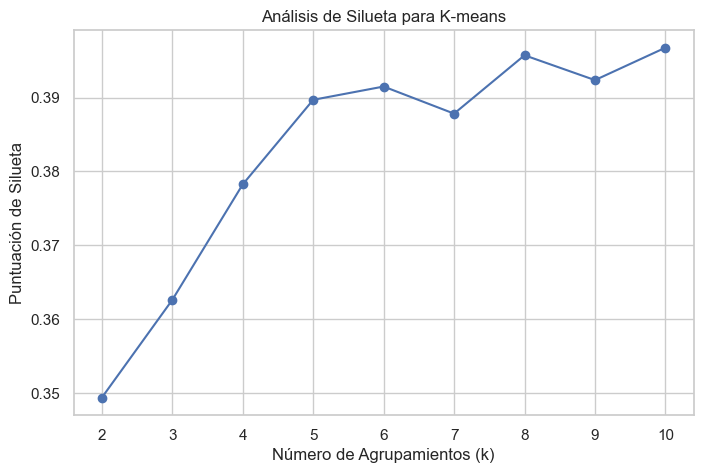

Métricas K-means:
  silhouette: 0.3626
  davies_bouldin: 0.9392
  calinski_harabasz: 2509.8876
  dunn: 0.0055
  adjusted_rand: 0.0000
  homogeneity: 0.1311
  completeness: 1.0000

Centroides en espacio UMAP:
  Agrupamiento 0: UMAP1=2.5902, UMAP2=7.7829
  Agrupamiento 1: UMAP1=4.4392, UMAP2=-3.7689
  Agrupamiento 2: UMAP1=-7.5162, UMAP2=-1.7573

Average features per cluster:
         THICK-MIN  THICK-AVG  THICK-LEFT-EDGE  THICK-RIGHT-EDGE  ASPERITYBOT  \
cluster                                                                         
0        56.289279  59.404127        59.450615         59.741916    32.412127   
1        56.177108  59.349655        59.908894         60.173132    32.329833   
2        56.238348  59.625471        59.401478         59.864087    32.493043   

         ASPERITYTOP  CARBONMEM   DENSITY   MDTBELONG   TDTBELONG  ...  \
cluster                                                            ...   
0          30.920914   2.310018  0.943328  474.144112  573.039543  ..

In [17]:
# Método del codo
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_reduced)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Número de Agrupamientos (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-means')
plt.show()

# Análisis de silueta
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_reduced)
    silhouette_scores.append(silhouette_score(X_reduced, labels))

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Número de Agrupamientos (k)')
plt.ylabel('Puntuación de Silueta')
plt.title('Análisis de Silueta para K-means')
plt.show()

# Elegir k óptimo (ej. k=3 basado en codo y silueta)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_reduced)

# Evaluar (usar etiquetas reducidas alineadas)
kmeans_metrics = evaluate_clustering(X_reduced, kmeans_labels, lot_labels_reduced)
print("Métricas K-means:")
for key, value in kmeans_metrics.items():
    if isinstance(value, str):
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {value:.4f}")

# Interpretar centroides en términos de pruebas de calidad
centroids = kmeans.cluster_centers_
print("\nCentroides en espacio UMAP:")
for i, centroid in enumerate(centroids):
    print(f"  Agrupamiento {i}: UMAP1={centroid[0]:.4f}, UMAP2={centroid[1]:.4f}")

# Características promedio por agrupamiento (subset si tamaños difieren)
if len(df_original) != len(X_reduced):
    df_original_subset = df_original.iloc[:len(X_reduced)].copy()
else:
    df_original_subset = df_original.copy()

df_original_subset['cluster'] = kmeans_labels
cluster_means = df_original_subset.groupby('cluster')[numerical_cols].mean()
print("\nAverage features per cluster:")
print(cluster_means)

## Agrupamiento DBSCAN

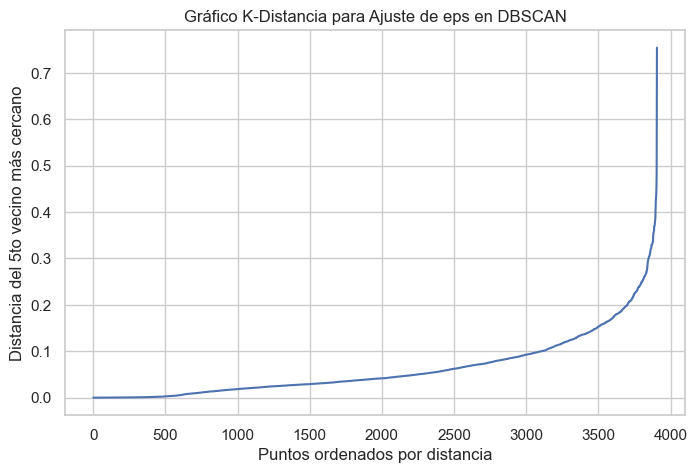

DBSCAN eps=0.3, min_samples=5: 283 agrupamientos, 16 puntos de ruido
DBSCAN eps=0.3, min_samples=10: 127 agrupamientos, 1096 puntos de ruido
DBSCAN eps=0.3, min_samples=15: 77 agrupamientos, 1959 puntos de ruido
DBSCAN eps=0.5, min_samples=5: 203 agrupamientos, 1 puntos de ruido
DBSCAN eps=0.3, min_samples=15: 77 agrupamientos, 1959 puntos de ruido
DBSCAN eps=0.5, min_samples=5: 203 agrupamientos, 1 puntos de ruido
DBSCAN eps=0.5, min_samples=10: 72 agrupamientos, 751 puntos de ruido
DBSCAN eps=0.5, min_samples=15: 50 agrupamientos, 1091 puntos de ruido
DBSCAN eps=0.5, min_samples=10: 72 agrupamientos, 751 puntos de ruido
DBSCAN eps=0.5, min_samples=15: 50 agrupamientos, 1091 puntos de ruido
DBSCAN eps=0.7, min_samples=5: 181 agrupamientos, 0 puntos de ruido
DBSCAN eps=0.7, min_samples=10: 58 agrupamientos, 701 puntos de ruido
DBSCAN eps=0.7, min_samples=5: 181 agrupamientos, 0 puntos de ruido
DBSCAN eps=0.7, min_samples=10: 58 agrupamientos, 701 puntos de ruido
DBSCAN eps=0.7, min_sam

In [19]:
# Gráfico K-distancia para ajustar eps
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_reduced)
distances, indices = neighbors_fit.kneighbors(X_reduced)
distances = np.sort(distances[:, 4])  # 5th neighbor

plt.figure(figsize=(8, 5))
plt.plot(distances)
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel('Distancia del 5to vecino más cercano')
plt.title('Gráfico K-Distancia para Ajuste de eps en DBSCAN')
plt.show()

# Ajustar eps y min_samples
# Basado en gráfico, elegir eps alrededor del punto de inflexión, digamos 0.5
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 15]

best_dbscan_score = -1
best_dbscan_params = {}
best_dbscan_labels = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_reduced)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        if n_clusters > 1:
            score = silhouette_score(X_reduced, labels)
            if score > best_dbscan_score:
                best_dbscan_score = score
                best_dbscan_params = {'eps': eps, 'min_samples': min_samples}
                best_dbscan_labels = labels
        print(f"DBSCAN eps={eps}, min_samples={min_samples}: {n_clusters} agrupamientos, {n_noise} puntos de ruido")

# Mejor DBSCAN
dbscan = DBSCAN(**best_dbscan_params)
dbscan_labels = dbscan.fit_predict(X_reduced)

# Evaluar (usar etiquetas reducidas alineadas)
dbscan_metrics = evaluate_clustering(X_reduced, dbscan_labels, lot_labels_reduced)
print("\nDBSCAN Metrics:")
for key, value in dbscan_metrics.items():
    if isinstance(value, str):
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {value:.4f}")

# Manejar ruido como anomalías
n_noise = list(dbscan_labels).count(-1)
print(f"\nNúmero de anomalías (puntos de ruido): {n_noise}")

## Agrupamiento Espectral

In [22]:
# Agrupamiento Espectral con diferentes kernels y n_clusters
kernels = ['rbf', 'nearest_neighbors']
n_clusters_list = [2, 3, 4, 5]

best_spectral_score = -1
best_spectral_params = {}
best_spectral_labels = None

for kernel in kernels:
    for n_clusters in n_clusters_list:
        spectral = SpectralClustering(n_clusters=n_clusters, affinity=kernel, random_state=42)
        labels = spectral.fit_predict(X_reduced)
        score = silhouette_score(X_reduced, labels)
        if score > best_spectral_score:
            best_spectral_score = score
            best_spectral_params = {'n_clusters': n_clusters, 'affinity': kernel}
            best_spectral_labels = labels
        print(f"Spectral {kernel}, n_clusters={n_clusters}: Silueta={score:.4f}")

# Mejor Espectral
spectral = SpectralClustering(**best_spectral_params, random_state=42)
spectral_labels = spectral.fit_predict(X_reduced)

# Evaluar (usar etiquetas reducidas alineadas)
spectral_metrics = evaluate_clustering(X_reduced, spectral_labels, lot_labels_reduced)
print("\nSpectral Clustering Metrics:")
for key, value in spectral_metrics.items():
    if isinstance(value, str):
        print(f"  {key}: {value}")
    else:
        print(f"  {key}: {value:.4f}")

Spectral rbf, n_clusters=2: Silueta=0.3217
Spectral rbf, n_clusters=3: Silueta=0.2522
Spectral rbf, n_clusters=3: Silueta=0.2522
Spectral rbf, n_clusters=4: Silueta=0.1177
Spectral rbf, n_clusters=4: Silueta=0.1177
Spectral rbf, n_clusters=5: Silueta=0.1240
Spectral rbf, n_clusters=5: Silueta=0.1240
Spectral nearest_neighbors, n_clusters=2: Silueta=0.1238
Spectral nearest_neighbors, n_clusters=2: Silueta=0.1238
Spectral nearest_neighbors, n_clusters=3: Silueta=-0.0236
Spectral nearest_neighbors, n_clusters=3: Silueta=-0.0236
Spectral nearest_neighbors, n_clusters=4: Silueta=-0.1449
Spectral nearest_neighbors, n_clusters=4: Silueta=-0.1449
Spectral nearest_neighbors, n_clusters=5: Silueta=-0.0773
Spectral nearest_neighbors, n_clusters=5: Silueta=-0.0773

Spectral Clustering Metrics:
  silhouette: 0.3217
  davies_bouldin: 0.9058
  calinski_harabasz: 759.3177
  dunn: 0.0547
  adjusted_rand: 0.0000
  homogeneity: 0.0324
  completeness: 1.0000

Spectral Clustering Metrics:
  silhouette: 0.3

## Visualización

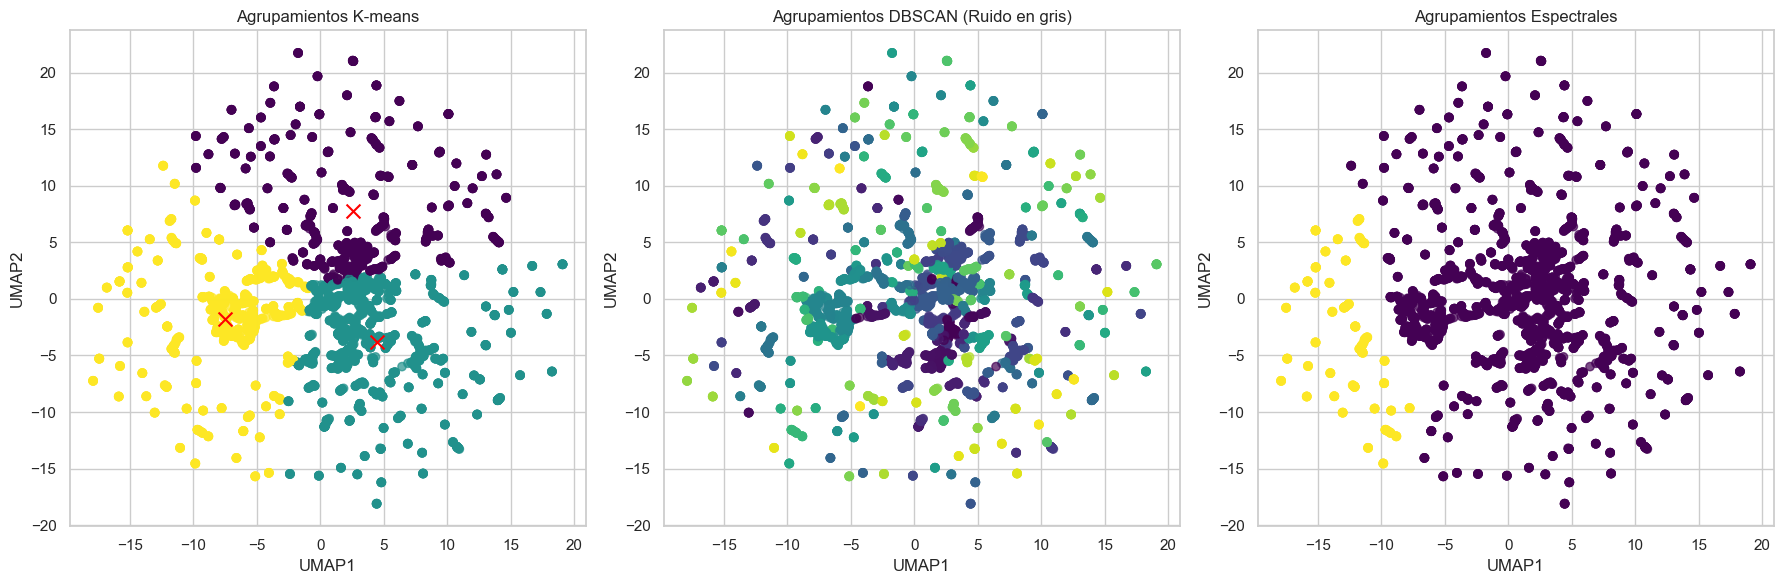

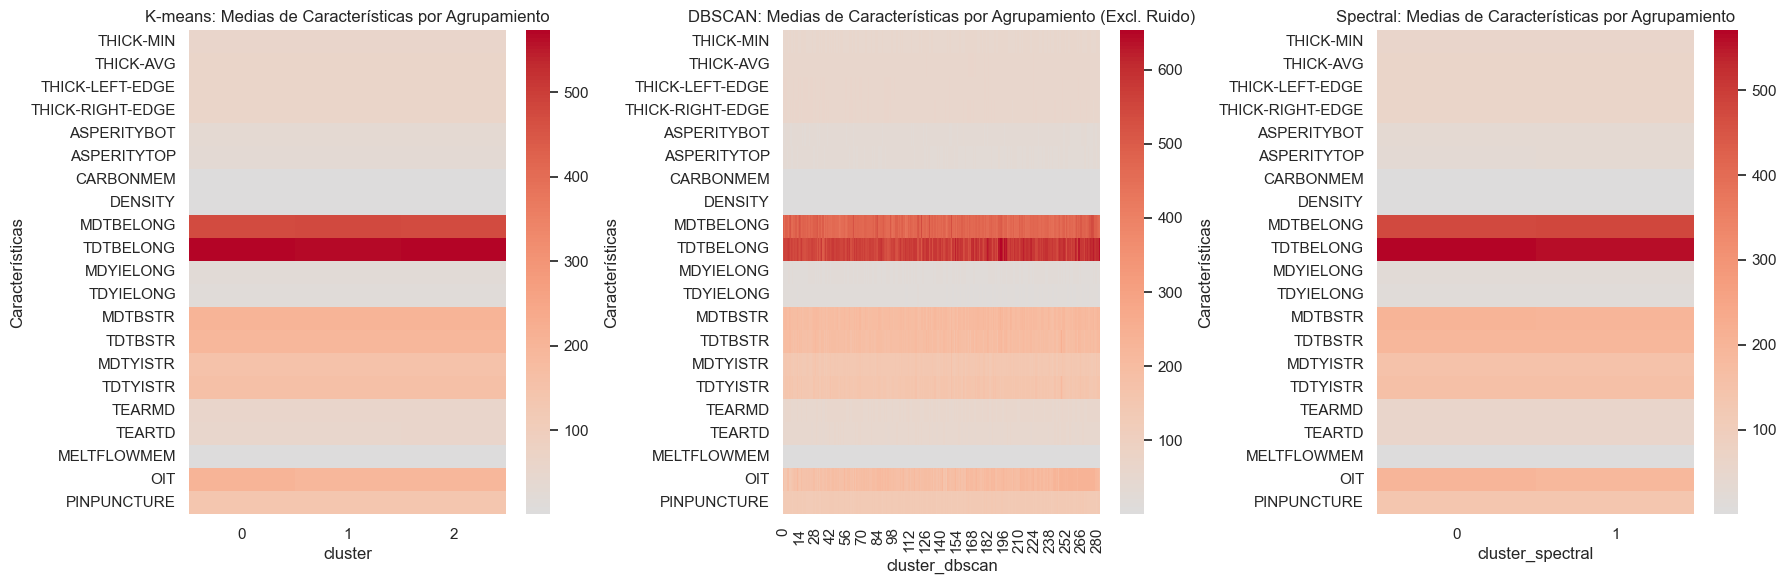

In [24]:
# Visualizar agrupamientos en espacio reducido
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-means
axes[0].scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[0].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100)
axes[0].set_title('Agrupamientos K-means')
axes[0].set_xlabel('UMAP1')
axes[0].set_ylabel('UMAP2')

# DBSCAN
axes[1].scatter(X_reduced[:, 0], X_reduced[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
axes[1].set_title('Agrupamientos DBSCAN (Ruido en gris)')
axes[1].set_xlabel('UMAP1')
axes[1].set_ylabel('UMAP2')

# Spectral
axes[2].scatter(X_reduced[:, 0], X_reduced[:, 1], c=spectral_labels, cmap='viridis', alpha=0.7)
axes[2].set_title('Agrupamientos Espectrales')
axes[2].set_xlabel('UMAP1')
axes[2].set_ylabel('UMAP2')

plt.tight_layout()
plt.show()

# Mapas de calor de características por agrupamiento
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# K-means
sns.heatmap(cluster_means.T, ax=axes[0], cmap='coolwarm', center=0)
axes[0].set_title('K-means: Medias de Características por Agrupamiento')
axes[0].set_ylabel('Características')

# DBSCAN (excluir ruido)
df_original_subset = df_original.iloc[:len(dbscan_labels)].copy()
df_original_subset['cluster_dbscan'] = dbscan_labels
dbscan_cluster_means = df_original_subset[df_original_subset['cluster_dbscan'] != -1].groupby('cluster_dbscan')[numerical_cols].mean()
sns.heatmap(dbscan_cluster_means.T, ax=axes[1], cmap='coolwarm', center=0)
axes[1].set_title('DBSCAN: Medias de Características por Agrupamiento (Excl. Ruido)')
axes[1].set_ylabel('Características')

# Spectral
df_original_subset['cluster_spectral'] = spectral_labels
spectral_cluster_means = df_original_subset.groupby('cluster_spectral')[numerical_cols].mean()
sns.heatmap(spectral_cluster_means.T, ax=axes[2], cmap='coolwarm', center=0)
axes[2].set_title('Spectral: Medias de Características por Agrupamiento')
axes[2].set_ylabel('Características')

plt.tight_layout()
plt.show()

## Justificación y Selección

In [25]:
# Comparar métricas
methods = ['K-means', 'DBSCAN', 'Spectral']
metrics_data = {
    'K-means': kmeans_metrics,
    'DBSCAN': dbscan_metrics,
    'Spectral': spectral_metrics
}

comparison_df = pd.DataFrame(metrics_data).T
print("Comparación de Métricas:")
print(comparison_df)

# Justificación
print("\n=== ALGORITMO SELECCIONADO ===")
print("K-means: Bueno para agrupamientos esféricos, centroides interpretables, pero asume convexidad.")
print("DBSCAN: Excelente para detectar anomalías (puntos de ruido), maneja formas arbitrarias, pero sensible a parámetros.")
print("Spectral: Bueno para agrupamientos no convexos, pero computacionalmente intensivo.")
print("\nPara control de calidad, detectar anomalías es crucial. DBSCAN es seleccionado por su capacidad para identificar puntos de ruido como potenciales defectos.")

# Seleccionar DBSCAN
best_algorithm = 'DBSCAN'
print(f"\nMejor algoritmo seleccionado: {best_algorithm}")

Comparación de Métricas:
          silhouette  davies_bouldin  calinski_harabasz      dunn  \
K-means     0.362592        0.939184        2509.887596  0.005491   
DBSCAN      0.607337        0.564115        5665.863415  0.010587   
Spectral    0.321748        0.905769         759.317729  0.054718   

          adjusted_rand  homogeneity  completeness  
K-means             0.0     0.131107           1.0  
DBSCAN              0.0     0.626373           1.0  
Spectral            0.0     0.032440           1.0  

=== ALGORITMO SELECCIONADO ===
K-means: Bueno para agrupamientos esféricos, centroides interpretables, pero asume convexidad.
DBSCAN: Excelente para detectar anomalías (puntos de ruido), maneja formas arbitrarias, pero sensible a parámetros.
Spectral: Bueno para agrupamientos no convexos, pero computacionalmente intensivo.

Para control de calidad, detectar anomalías es crucial. DBSCAN es seleccionado por su capacidad para identificar puntos de ruido como potenciales defectos.

Me